# A note on simulation resolution and beam

`meer21cm` generates mock HI field first in a rectangular box, and then projects the box to `wcs` projected sky maps, and then convolves with a beam to generate the mock HI map cube. In this process, the power spectrum statistics is bound to be somewhat distorted. In this notebook, we demonstrate some of these inaccuracies.



## Mock simulation in the rectangular box

In [1]:
from meer21cm import MockSimulation
import numpy as np
import matplotlib.pyplot as plt
from meer21cm.util import create_wcs
from meer21cm.telescope import dish_beam_sigma
from meer21cm.plot import plot_map

/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


(array([1419.97079959, 1419.97079963,  747.72460271]),
 array([15.60407472, 15.60407472, 22.65832129]))

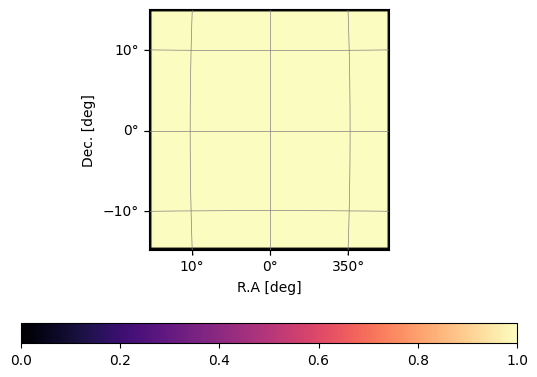

In [2]:
num_pix_x = 100
num_pix_y = 100
ang_resol = 0.3
wcs = create_wcs(0,0,[num_pix_x,num_pix_y],ang_resol)
nu = np.linspace(800,900,51) * 1e6
d_dish = 13.5
sigma_beam_ch = dish_beam_sigma(d_dish, nu)
mock = MockSimulation(
    seed=1234,
    nu=nu,
    wproj=wcs,
    #sigma_beam_ch=sigma_beam_ch,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    omega_hi=5e-4,
    tracer_bias_1=1.5,
    mean_amp_1='average_hi_temp',
    density='gaussian',
    kmax=15.0,
)
plot_map(mock.W_HI,mock.wproj)
mock.get_enclosing_box()
mock.box_len,mock.box_resol



You can then simulate the HI density field in the box:

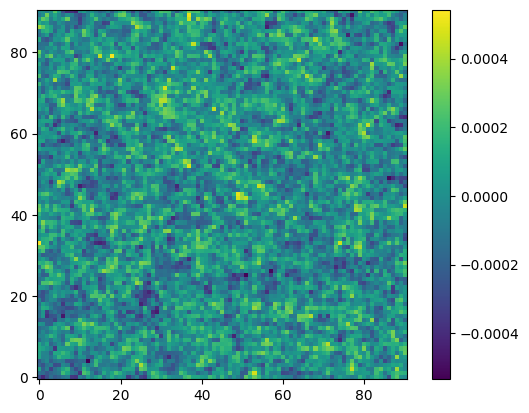

In [3]:
plt.imshow(mock.mock_tracer_field_1[:,:,0],origin='lower')
plt.colorbar()

For the purpose of this tutorial, we set the density distribution `density='gaussian'`, which allows better visualisation of the projections due to white-noise structure

You can then project the mock field to the sky map:

In [4]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)

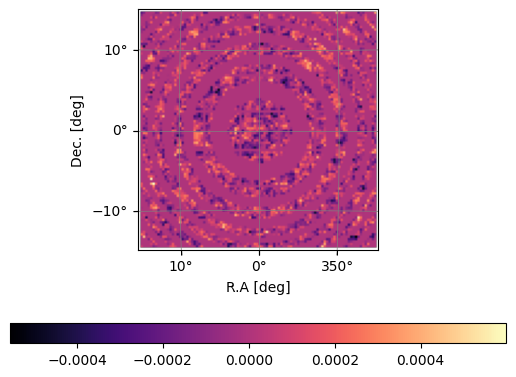

In [5]:
plot_map(mock.data[:,:,0],mock.wproj, W=mock.W_HI[:,:,0])

You can see by eye that there is a ring-like structure in the image. This is due to the fact that, we did not specify what resolution do we want. By default, the box resolution is taken to be roughly:

In [6]:
[
    mock.pix_resol_in_mpc * mock.downres_factor_transverse,
    mock.pix_resol_in_mpc * mock.downres_factor_transverse,
    mock.los_resol_in_mpc * mock.downres_factor_radial,
], mock.box_resol

([np.float64(15.698099048719225),
  np.float64(15.698099048719225),
  np.float64(23.35887910447778)],
 array([15.60407472, 15.60407472, 22.65832129]))

The small difference is due to keeping the box length and integer number of grids. The box is roughly the same resolution of the sky map cube, but sky is curved and there is a rotation. Therefore, the sampling of box voxels to map cube pixels is not high enough, leaving rings of unsampled pixels, creating the ring structure.

A simple solution is to upscale the resolution:

In [7]:
mock.downres_factor_radial = 1/4.0
mock.downres_factor_transverse = 1/4.0
mock.get_enclosing_box()
mock.box_resol

array([3.26430069, 3.26430069, 2.90943425])

And redo the simulation:

In [8]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)

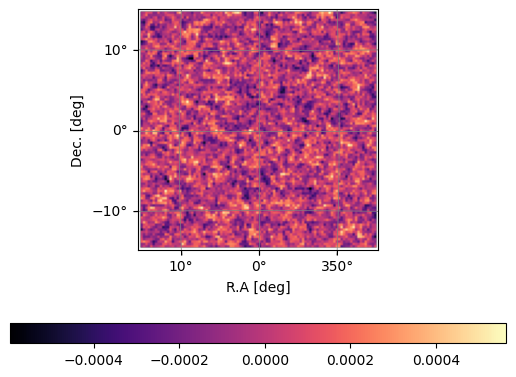

In [9]:
plot_map(mock.data[:,:,0],mock.wproj, W=mock.W_HI[:,:,0])

Generally speaking, higher resolution also reduces effects of generating mock field on a grid instead of having discrete particles. One thing to note is that, the maximum k to calculate the matter power spectrum is set by `kmax`. You need to double check that `mock.kmax` is high enough for your resolution.

Now let us regrid the sky map to a lower resolution box and check the power spectrum:

In [10]:
mock.downres_factor_radial = 2.0
mock.downres_factor_transverse = 2.0
mock.get_enclosing_box()
mock.grid_scheme = 'tsc'
himap_lowres,_,_  = mock.grid_data_to_field()

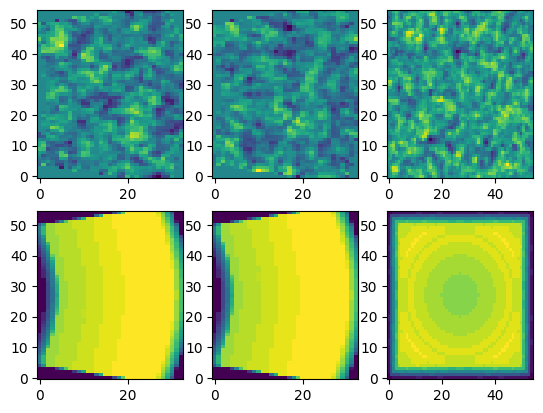

In [11]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    # first row is the gridded HI field
    axes[0,i].imshow(
        himap_lowres.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    # second row is the sampling of pixels in the box grids
    axes[1,i].imshow(
        (mock.counts_in_box>0).mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

The lower panels show the number of pixels that fall into each box grid. Note the structures: Along the line-of-sight, the lightcone-shape means that the pixel count is getting larger and larger as you go further away. Projected onto the transverse plane, it means that there is again some ring-like structures. This is the consequence of the geometry. What is important is to make sure that the sampling is full inside the lightcone.

In [12]:
mock.field_1 = himap_lowres
mock.weights_field_1 = (mock.counts_in_box>0).astype('float')
mock.weights_grid_1 = None
mock.mean_center_1 = False
mock.unitless_1 = False
mock.include_sky_sampling = [True, False]
mock.include_beam = [True, False]
mock.compensate = True

In [13]:
mock.k1dbins = np.linspace(8e-3, 2e-1, 21)
pmock_1d,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_1)
pmodel_1d,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)

Text(0, 0.5, 'k^2 P(k) [K^2 Mpc^1]')

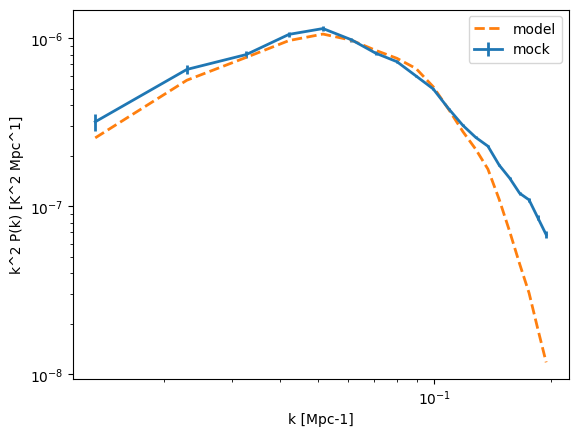

In [14]:
k_factor = keff**2
plt.errorbar(keff,pmock_1d * k_factor,yerr= pmock_1d/np.sqrt(nmodes-1) * k_factor,label='mock',ls='-',lw=2)
plt.plot(keff,pmodel_1d * k_factor,label='model',ls='--',lw=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('k^2 P(k) [K^2 Mpc^1]')

So far so good. You can see that at k>0.1 the accuracy falls off, because of the inner-grid shot-noise. Now let us add in the beam:

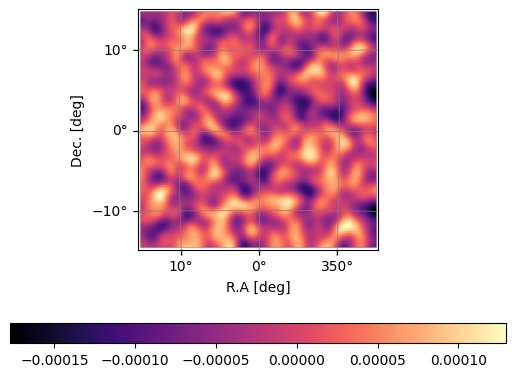

In [15]:

mock = MockSimulation(
    seed=1234,
    nu=nu,
    wproj=wcs,
    sigma_beam_ch=sigma_beam_ch,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    omega_hi=5e-4,
    tracer_bias_1=1.5,
    mean_amp_1='average_hi_temp',
    density='gaussian',
    kmax=15.0,
    downres_factor_radial = 1/4.0,
    downres_factor_transverse = 1/4.0,
)
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)
plot_map(mock.data[:,:,0],mock.wproj, W=mock.W_HI[:,:,0])


In [16]:
mock.downres_factor_radial = 2.0
mock.downres_factor_transverse = 2.0
mock.get_enclosing_box()
mock.grid_scheme = 'tsc'
himap_lowres,_,_  = mock.grid_data_to_field()

mock.field_1 = himap_lowres
mock.weights_field_1 = (mock.counts_in_box>0).astype('float')
mock.k1dbins = np.linspace(8e-3, 2e-1, 21)
pmock_beam_1d,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_1)
pmodel_beam_1d,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)

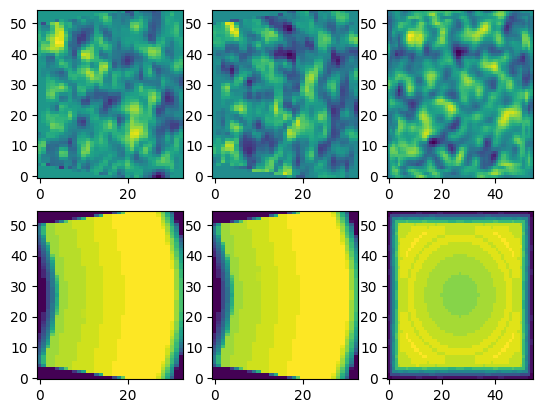

In [17]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    # first row is the gridded HI field
    axes[0,i].imshow(
        himap_lowres.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    # second row is the sampling of pixels in the box grids
    axes[1,i].imshow(
        (mock.counts_in_box>0).mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

Text(0, 0.5, 'k^2 P(k) [K^2 Mpc^1]')

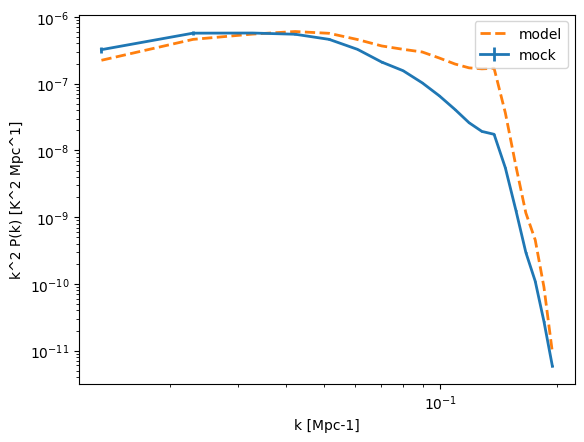

In [18]:
k_factor = keff**2
plt.errorbar(keff,pmock_beam_1d * k_factor,yerr= pmock_beam_1d/np.sqrt(nmodes-1) * k_factor,label='mock',ls='-',lw=2)
plt.plot(keff,pmodel_beam_1d * k_factor,label='model',ls='--',lw=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('k^2 P(k) [K^2 Mpc^1]')

You can see that the accuracy falls off quite a lot. Of course, from the model PS, one can see that towards high-k, the beam attenuation is too severe and is not of interest. We should therefore cut off the high k-modes near the Nyquist frequency:

In [19]:
k_xyz_max = [mock.k_nyquist[0]*0.5,mock.k_nyquist[1]*0.5,mock.k_nyquist[2]*0.5]

In [20]:
# smaller k-range due to cuts
mock.k1dbins = np.linspace(8e-3, 1e-1, 11)
pmock_cutoff_1d,keff_cutoff,nmodes_cutoff = mock.get_1d_power(mock.auto_power_3d_1, k_xyz_max=k_xyz_max)
pmodel_cutoff_1d,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)

Text(0, 0.5, 'k^2 P(k) [K^2 Mpc^1]')

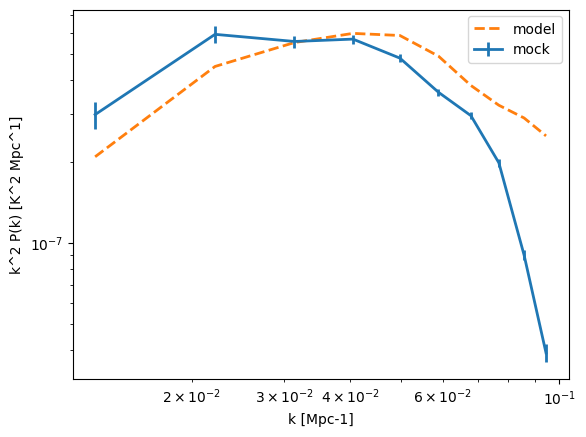

In [21]:
k_factor = keff_cutoff**2
plt.errorbar(keff_cutoff,pmock_cutoff_1d * k_factor,yerr= pmock_cutoff_1d/np.sqrt(nmodes_cutoff-1) * k_factor,label='mock',ls='-',lw=2)
plt.plot(keff_cutoff,pmodel_cutoff_1d * k_factor,label='model',ls='--',lw=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('k^2 P(k) [K^2 Mpc^1]')

You can see the amplitude starts to match but is still quite inaccurate.

There are several reasons for this

First, primary beam is frequency-dependent, and convolves with the signal on the sky. On the modelling side, it is modelled by an effective $\sigma_{\rm beam}$ term that acts only on $k_\perp$ in the flat-sky limit. This is not accurate and the formalism for modelling it beyond this limit is not clear. It compounds with the mass assignment scheme used for gridding, which further causes inaccuracy. Using lower-order mass assignment scheme helps in this case.

Second, the convolution itself is inaccurate. `meer21cm` uses `astropy.wcs` projection to create the mock HI map and also the primary beam image, and convolves them by treating the two images as cartesian grid images (i.e. they are convolved by multiplication in Fourier space).

Third, the beam convolution is inaccurate around the edge of the map. A way to resolve this is to have a bigger simulation and then cut off the edges.

Finally, while we have set the simulation resolution to be high enough, the convolution of the beam and the mock signal still happens at the orignal resolution. Suppose you change the angular resolution of the map:

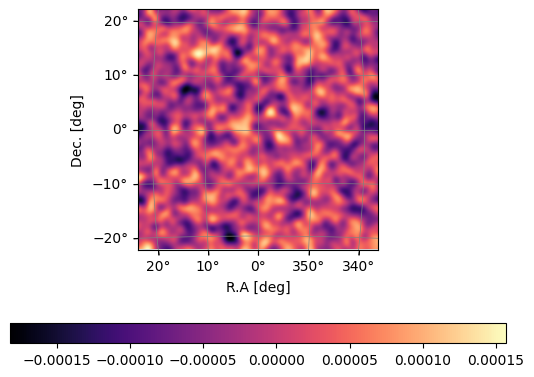

In [30]:
wcs_highres = create_wcs(
    0,0,
    [num_pix_x*2+100,num_pix_x*2+100], # some buffer to avoid edge effects
    0.15, # 2x resolution
)
mock_highres = MockSimulation(
    seed=1234,
    nu=nu,
    wproj=wcs_highres,
    sigma_beam_ch=sigma_beam_ch,
    num_pix_x=num_pix_x*2+100,
    num_pix_y=num_pix_y*2+100,
    omega_hi=5e-4,
    tracer_bias_1=1.5,
    mean_amp_1='average_hi_temp',
    density='gaussian',
    kmax=15.0,
    downres_factor_radial = 1/4.0,
    downres_factor_transverse = 1/2.0,
)
mock_highres.data = mock_highres.propagate_mock_field_to_data(mock_highres.mock_tracer_field_1)
plot_map(mock_highres.data[:,:,0],mock_highres.wproj, W=mock_highres.W_HI[:,:,0])


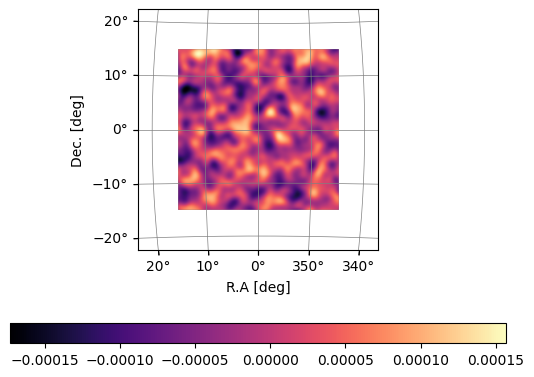

In [32]:
# cut off the edges of the map
mock_highres.W_HI = np.zeros_like(mock_highres.W_HI)
mock_highres.W_HI[50:-50,50:-50,:] = 1
mock_highres.w_HI = mock_highres.W_HI.astype('float')
plot_map(mock_highres.data[:,:,0],mock_highres.wproj, W=mock_highres.W_HI[:,:,0])

Then, you should avoid scales too close to the resolution as well as the size of the box:

In [92]:
mock_highres.downres_factor_radial = 2.0
mock_highres.downres_factor_transverse = 4.0
mock_highres.get_enclosing_box()
mock_highres.grid_scheme = 'nnb'
himap_lowres,_,_  = mock_highres.grid_data_to_field()

In [93]:
mock_highres.field_1 = himap_lowres
mock_highres.weights_field_1 = (mock_highres.counts_in_box).astype('float')
mock_highres.k1dbins = np.linspace(8e-3, 1e-1, 11)

In [108]:
k_xyz_max = mock_highres.k_nyquist * 0.5
k_xyz_min = mock_highres.k_nyquist * 0.05
pmock_highres_1d,keff_higres,nmodes_highres = mock_highres.get_1d_power(mock_highres.auto_power_3d_1,k_xyz_max=k_xyz_max,k_xyz_min=k_xyz_min)
pmodel_highres_1d,_,_ = mock_highres.get_1d_power(mock.auto_power_tracer_1_model)

Text(0, 0.5, 'k^2 P(k) [K^2 Mpc^1]')

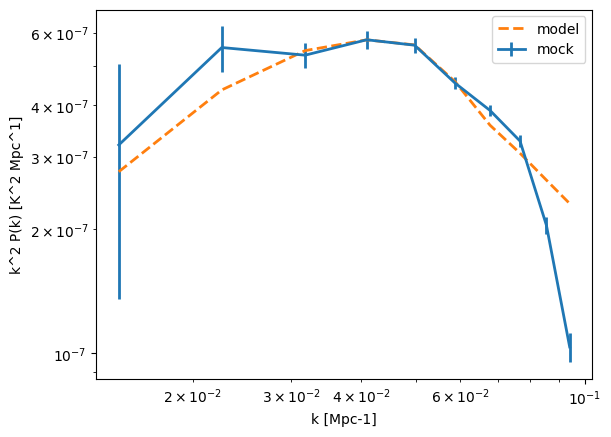

In [109]:
k_factor = keff_higres**2
plt.errorbar(keff_higres,pmock_highres_1d * k_factor,yerr= pmock_highres_1d/np.sqrt(nmodes_highres-1) * k_factor,label='mock',ls='-',lw=2)
plt.plot(keff_higres,pmodel_highres_1d * k_factor,label='model',ls='--',lw=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('k^2 P(k) [K^2 Mpc^1]')

In [123]:
import numpy as np
from meer21cm.power import PowerSpectrum, power_weights_renorm

if True:
    sp = PowerSpectrum(
        sampling_resol="auto",
        survey="meerklass_2021",
        band="L",
    )
    sp.data = np.random.normal(size=sp.map_has_sampling.shape) * sp.map_has_sampling
    ps = sp
    ps.downres_factor_transverse = 1.5
    ps.downres_factor_radial = 2.0
    ps.box_buffkick = 10
    ps.compensate = False
    noise_map, noise_weights, pix_counts = ps.grid_data_to_field()
    ps.field_1 = noise_map
    ps.weights_field_1 = (ps.counts_in_box>0).astype('float')
    ps.weights_grid_1 = None
    renorm = power_weights_renorm(ps.weights_grid_1, ps.weights_grid_1)
    sigma_n = np.zeros_like(ps.field_1)
    sigma_n[ps.counts_in_box > 0] = np.sqrt(1 / ps.counts_in_box[ps.counts_in_box > 0])
    ptn = (sigma_n**2).mean() * np.prod(ps.box_resol) * renorm

In [122]:
ptn, ps.auto_power_3d_1.mean(), renorm

(np.float64(36.918582031987356), np.float64(36.91123673839959), 1.0)